   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


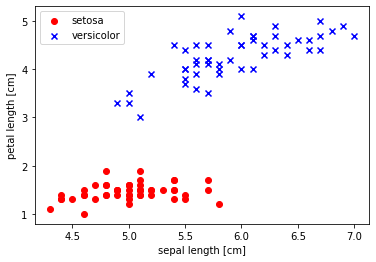

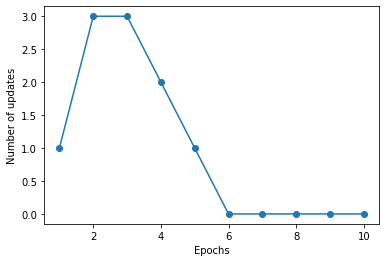

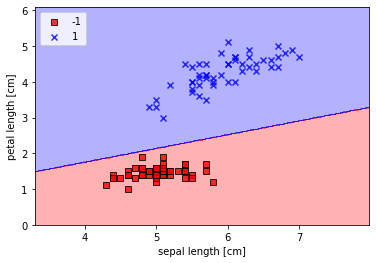

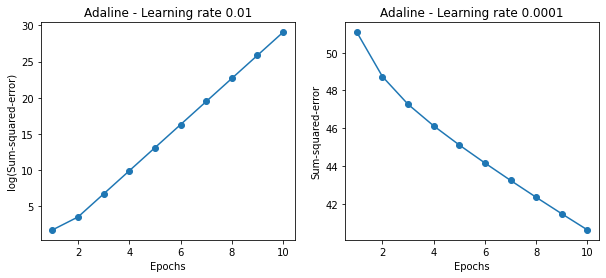

In [63]:

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets

class Perceptron(object):
    '''Классификация на основе персептрона.
    Параметры
    _________
    eta:float
        Скорость обучения
    n_iter:int
        Проходы по обучающему набору данных
    random_state:int
        Начальное значение генератора 
        случайных чисел для инициализации 
        случайными весами
    Атрибуты
    ________
    w_: list
        Веса после подгонки
    errors_: list
        Количество неправильных классификаций в каждой эпохе
    '''
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        '''Подгоняет к обучающим данным
        Параметры
        _________
        X: массив, форма = [n_examples, n_features]
            Обучающие векторы, где n_examples - количество образцов
            и n_features - количество признаков
        y: массив, форма = [n_examples]
            Целевые значения
        Возвращает
        __________
        self: object
        '''
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        '''Вычисляет общий вход'''
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        '''Возвращает метку класса после единичного шага'''
        return np.where(self.net_input(X) >= 0.0, 1, -1)



v1 = np.array([1, 2, 3])
v2 = 0.5 * v1
np.arccos(v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

df = pd.read_csv('iris.csv')  
print(df.head())
y = df.iloc[0:100, 5].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [1, 3]].values
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

class AdalineGD(object):
    '''Классификатор на основе адаптивного линейного нейрона.
	Параметры
	_________
	eta:float
		Скорость обучения (между 0.0 и 1.0)
	n iter : int
		Проходы по обучающему набору данных.
    shuffle : bool (по умолчанию: True)
        Если True, тогда тасовать обучающие данные во избежание циклов.
	random state : int
		Начальное значение генератора случайных чисел
		для инициализации случайными весами.
	Атрибуты
	________
	w : одномерный массив
		Веса после подгонки.
	cost : список
		Значение функции издержек на основе суммы квадратов
		в каждой эпохе.
	'''
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        '''Подгоняет к обучающим данным.
		Параметры
		_________
		Х : {подобен массиву}, форма = [n_examples , n_features]
			Обучающие векторы, где n_examples - количество образцов ,
			n_features - количество признаков.
		у : подобен массиву , форма = [n_examples]
			Целевые значения.
		Возвращает
		__________
		self : object
		'''
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return X
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()


In [64]:
X_std = np.copy(X)

In [65]:
X_std[:,0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:,0] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

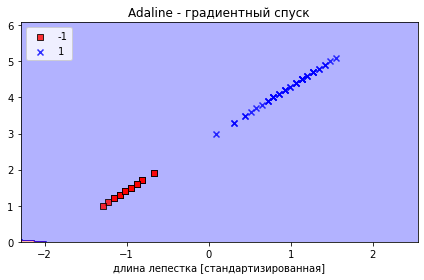

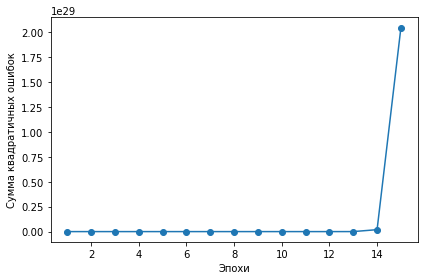

In [66]:
ada_gd = AdalineGD(n_iter=15, eta=0.01)
ada_gd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - градиентный спуск')
plt.xlabel('длина чашелистика [стандартизированная]')
plt.xlabel('длина лепестка [стандартизированная]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_gd.cost_) + 1),
        ada_gd.cost_, marker='o')
plt.xlabel('Эпохи')
plt.ylabel('Сумма квадратичных ошибок')
plt.tight_layout()
plt.show()